Files in save folder:
2-run/
    config.csv
    6ac-100-superdiverse/
        numpy/
            myopic_steps_runs_seed_3.npy
            myopic_runs_seed_3.npy
            myopic_runs_seed_2.npy
            myopic_steps_runs_seed_2.npy
            myopic_runs_seed_1.npy
            myopic_steps_runs_seed_1.npy
            proactive_steps_runs_seed_2.npy
            proactive_steps_runs_seed_3.npy
            proactive_steps_runs_seed_1.npy
            proactive_runs_seed_3.npy
            proactive_runs_seed_2.npy
            proactive_runs_seed_1.npy


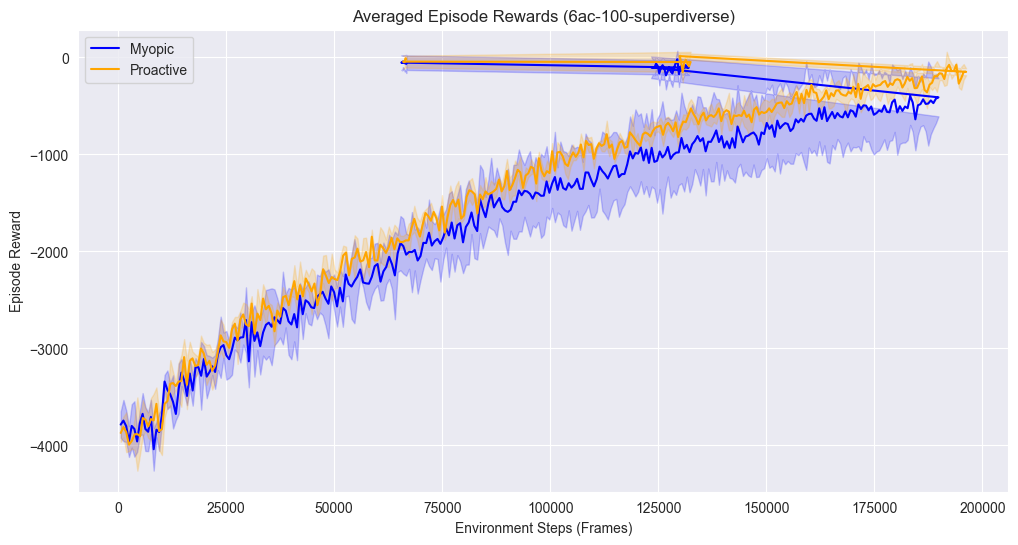

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")

###################################
# User parameters
###################################
save_folder = "../2-run" 
###################################

# Print all files in the folder
print("Files in save folder:")
if os.path.exists(save_folder):
    for root, dirs, files in os.walk(save_folder):
        level = root.replace(save_folder, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")
else:
    print(f"The folder '{save_folder}' does not exist.")

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Identify all scenario folders inside the save_folder
if not os.path.exists(save_folder):
    raise FileNotFoundError(f"The folder '{save_folder}' does not exist.")

scenario_folders = [
    f for f in os.listdir(save_folder) 
    if os.path.isdir(os.path.join(save_folder, f)) and f != 'numpy' and f != 'config.csv'  # Exclude numpy dir and config file
]

for scenario in scenario_folders:
    scenario_path = os.path.join(save_folder, scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue
        
    # Group files by agent type
    agent_data = {}
    for file in numpy_files:
        # Extract agent type and whether it's runs or steps
        if 'runs_seed_' in file and not 'steps' in file:  # Modified to correctly identify runs files
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        # Load the data
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

    # Plot data for each agent type that has complete data
    plt.figure(figsize=(12,6))
    colors = {'myopic': 'blue', 'proactive': 'orange', 'reactive': 'green'}
    
    for agent_type, data in agent_data.items():
        if len(data['runs']) == 0 or len(data['steps']) == 0:  # Modified condition
            print(f"Skipping {agent_type} - missing runs or steps data")
            continue
            
        # Pad arrays to same length before converting to numpy array
        max_len = max(len(run) for run in data['runs'])
        padded_runs = []
        for run in data['runs']:
            if len(run) < max_len:
                padded = np.pad(run, (0, max_len - len(run)), 'constant', constant_values=0)
                padded_runs.append(padded)
            else:
                padded_runs.append(run)
                
        # Pad steps arrays to same length
        max_steps_len = max(len(step) for step in data['steps'])
        padded_steps = []
        for step in data['steps']:
            if len(step) < max_steps_len:
                padded = np.pad(step, (0, max_steps_len - len(step)), 'constant', constant_values=0)
                padded_steps.append(padded)
            else:
                padded_steps.append(step)
                
        # Convert lists to numpy arrays
        runs = np.array(padded_runs)
        steps = np.array(padded_steps)
        
        # Compute statistics
        mean_runs = np.nanmean(runs, axis=0)
        std_runs = np.nanstd(runs, axis=0)
        mean_steps = np.nanmean(steps, axis=0).astype(int)
        
        # Apply smoothing
        smooth_window = 1
        mean_runs_sm = smooth(mean_runs, smooth_window)
        std_runs_sm = smooth(std_runs, smooth_window)
        
        if isinstance(mean_runs_sm, (float, np.float64)):
            steps_sm = mean_steps
        else:
            steps_sm = mean_steps[:len(mean_runs_sm)]
            
        # Plot with explicit label
        label = agent_type.capitalize()
        plt.plot(steps_sm, mean_runs_sm, label=label, color=colors.get(agent_type, 'gray'))
        
        if not isinstance(mean_runs_sm, (float, np.float64)):
            plt.fill_between(steps_sm,
                           mean_runs_sm - std_runs_sm,
                           mean_runs_sm + std_runs_sm,
                           alpha=0.2, color=colors.get(agent_type, 'gray'))

    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    plt.title(f"Averaged Episode Rewards ({scenario})")
    plt.legend()
    plt.grid(True)
    plt.show()
